In [106]:
from itertools import islice
import json
import pathlib
import cv2
from ultralytics import YOLO
from dataset import RDDDataset
from tqdm import tqdm
from ultralytics.yolo.utils.plotting import Annotator
import matplotlib.pyplot as plt


In [107]:
train_idx = 200
model_file = (
        (pathlib.Path())
        / "../runs"
        / "detect"
        / f'train{train_idx if train_idx else ""}'
        / "weights"
        / "best.pt"
    )
print(model_file.absolute())

/mnt/disks/sdb/TDT4265_project/yolo/../runs/detect/train200/weights/best.pt


In [108]:
model = YOLO(model_file.absolute(), task="detect")

In [109]:
img_gen = RDDDataset.get_test_images()

Loading test images:   0%|          | 0/2040 [07:16<?, ?it/s]


Loading test images:   0%|          | 0/2040 [00:00<?, ?it/s]

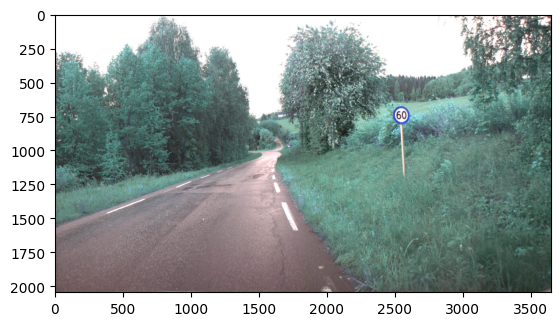

In [110]:
id_, im0 = img_gen.__next__()
plt.imshow(im0)

In [111]:
pred = model(im0)

pred2 = model(cv2.resize(im0, dsize=(640, 640)))


0: 384x640 1 d00, 31.2ms
Speed: 0.5ms preprocess, 31.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 d00, 2 d20s, 42.2ms
Speed: 0.5ms preprocess, 42.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


In [112]:
sz_x, sz_y = 640 * 2, 640 * 2

imgs_x = (im0.shape[1] // sz_x) + 2
imgs_y = (im0.shape[0] // sz_y) + 2
h, w = im0.shape[:2]
print((imgs_x, imgs_y))
print((w, h))

import numpy as np

dx = np.linspace(sz_x/2, w - sz_x/2, imgs_x)
dy = np.linspace(sz_y/2, h - sz_y/2, imgs_y)

(4, 3)
(3650, 2044)


In [113]:
print(dx)
print(dy)

[        640        1430        2220        3010]
[        640        1022        1404]


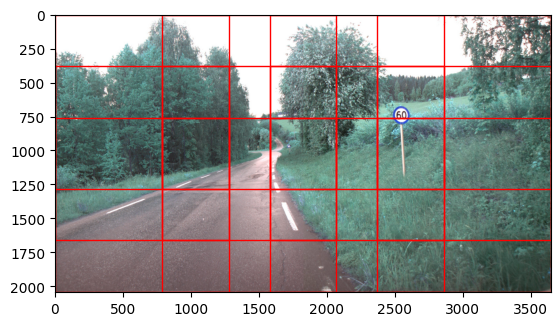

In [114]:
from matplotlib.patches import Rectangle

fig, ax = plt.subplots()
ax.imshow(im0)
for x in dx:
    for y in dy:
        ax.add_patch(Rectangle((x - sz_x / 2, y - sz_y / 2), sz_x, sz_y,edgecolor='red',                   facecolor='none',
                               ))
plt.show()

In [115]:
from copy import deepcopy
from typing import Tuple

import torch


class ImageFragment:
    def __init__(self, img, center: Tuple[int, int]) -> None:
        self.im = img
        self.center = center
        self.shape = self.im.shape
        self.translate = torch.tensor([self.center[1] - self.shape[1] / 2, self.center[0] - self.shape[0] / 2]).cuda()
        
    def to_global_result(self, result):
        glob_res = deepcopy(result)
        for box in glob_res.boxes:
            box.xyxy[0, :2] += self.translate
            box.xyxy[0, 2:] += self.translate
            box.xywh[0, :2] += self.translate
        return glob_res

In [116]:
fragments = []
for x in dx:
    for y in dy:
        x_start = int(round(x - sz_x / 2))
        x_end = int(round(x + sz_x / 2))
        y_start = int(round(y - sz_y / 2))
        y_end = int(round(y + sz_y / 2))
        img_seg = im0[y_start:y_end,x_start:x_end]
        fragments.append(
            ImageFragment(
                img=img_seg,
                center=(int(round(x)), int(round(y)))
            )
        )

In [117]:
results = [
    (frag, model(frag.im)[0])
    for frag in fragments
]


0: 640x640 (no detections), 39.0ms
Speed: 0.7ms preprocess, 39.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 38.8ms
Speed: 0.6ms preprocess, 38.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 38.7ms
Speed: 0.5ms preprocess, 38.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 30.1ms
Speed: 0.6ms preprocess, 30.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 d20, 27.8ms
Speed: 0.5ms preprocess, 27.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 28.1ms
Speed: 0.5ms preprocess, 28.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 28.1ms
Speed: 0.5ms preprocess, 28.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 27.7ms
Speed: 0.5ms preprocess, 27.7ms inference, 

In [118]:
global_results = [
    frag.to_global_result(result)
    for frag, result in results
]

tensor([1060.4757, 1619.7665, 1228.1898, 1896.1862], device='cuda:0')
tensor([ 833.3347, 2552.4470,  889.5782, 2853.7131], device='cuda:0')
tensor([ 840.5714, 2591.5156,  885.9579, 2852.0806], device='cuda:0')


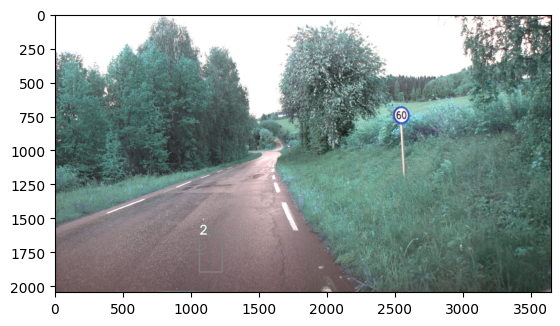

In [119]:
annotator = Annotator(im0)
for result in global_results:
    boxes = result.boxes
    for box in boxes:
        print(box.xyxy[0])
        b = box.xyxy[0]  # get box coordinates in (top, left, bottom, right) format
        c = box.cls
        annotator.box_label(b, str(int(c.item())))
frame = annotator.result()
plt.imshow(frame)


In [120]:
frame.shape

(2044, 3650, 3)